# References

### CLIP
http://proceedings.mlr.press/v139/radford21a/radford21a.pdf

### Grad-CAM
https://openaccess.thecvf.com/content_iccv_2017/html/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.html

### 참고 코드 원본 (XAI Recipes for the HuggingFace 🤗 Image Classification Models)
https://jacobgil.github.io/pytorch-gradcam-book/HuggingFace.html

### HuggingFace Models 
https://huggingface.co/models?sort=downloads

# Functions

In [1]:
from PIL import Image
import requests
import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
from datasets import load_dataset
from pytorch_grad_cam import run_dff_on_image, GradCAM
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional


def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]
    
    
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module,
                          input_image: Image,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:
        # Replicate the tensor for each of the categories we want to create Grad-CAM for:
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)
        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
    
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            # Make it weight less in the notebook:
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
        return np.hstack(results)
    
    
# def print_top_categories(model, img_tensor, top_k=5):
#     logits = model(img_tensor.unsqueeze(0)).logits
#     indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1]
#     for i in indices:
#         print(f"Predicted class {i}: {model.config.id2label[i]}")
        
        
class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]
    

    
def reshape_transform_vit_huggingface(x):
    activations = x[:, 1:, :]
    activations = activations.view(activations.shape[0],
                                   7, 7, activations.shape[2])
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations

# Model Load

In [2]:
from transformers import CLIPModel, CLIPProcessor, AutoProcessor

clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Toy Experiments

## 1. Sample Image

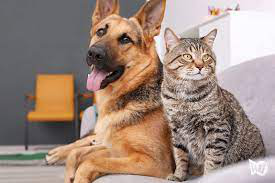

In [27]:
# url = "https://public-vcrdata.s3.ap-northeast-2.amazonaws.com/blog/images/horse_wagon.jpg"
# url = "https://public-vcrdata.s3.ap-northeast-2.amazonaws.com/blog/images/Family+and+a+Car.jpg"
url = "https://public-vcrdata.s3.ap-northeast-2.amazonaws.com/blog/images/dog_cat.jpg"

image = Image.open(requests.get(url, stream=True).raw)
img_tensor = transforms.ToTensor()(image)
image

## 2. Grad-CAM의 Target Layer 결정 

#### 1) 몇 번째 Transformer Layer(e.g., 1 Layer, 12 Layer)를 타겟으로 할지
#### 2) 어떤 Linear Layer(e.g., self_attn.output_proj, mlp.fc1, mlp.fc2)를 타겟으로 할지



#### (*참고) CLIP 모델 Vision Encoder의 Encoder Layer 구조:

In [28]:
clip.vision_model.encoder.layers[0]

CLIPEncoderLayer(
  (self_attn): CLIPAttention(
    (k_proj): Linear(in_features=768, out_features=768, bias=True)
    (v_proj): Linear(in_features=768, out_features=768, bias=True)
    (q_proj): Linear(in_features=768, out_features=768, bias=True)
    (out_proj): Linear(in_features=768, out_features=768, bias=True)
  )
  (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): CLIPMLP(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
  )
  (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

## 3. Prompts 결정
- CLIP의 Text Encoder에 입력할 prompt. 
- 이미지 분류를 위한 일종의 class.

### Example  Prompts
-  "a photo of a cat" 
- "a photo of a dog"
-  "a photo of a dog and a cat"

In [29]:
prompts = ["a photo of a cat.", "a photo of a dog.", "a photo of a dog and a cat."]

In [30]:
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        image = Image.open(requests.get(url, stream=True).raw)
        inputs = processor(
            text=prompts, images=image, return_tensors="pt", padding=True)
        
        output = clip(**inputs)
        return output.logits_per_image

# 실험1)  같은 Transformer Layer 내에서 Target Layer 비교
- self_attn.out_proj (셀프 어텐션의 projection layer)  
v.s. 
- mlp.fc1 (Fully Connected Layer)

## (1) 셀프 어텐션의 Projection Layer

Prompt :  a photo of a cat.


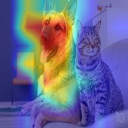

Prompt :  a photo of a dog.


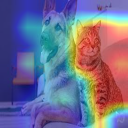

Prompt :  a photo of a dog and a cat.


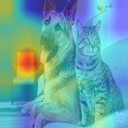

In [31]:
target_layer_gradcam = clip.vision_model.encoder.layers[-2].self_attn.out_proj 
image_resized = image.resize((256, 256))
tensor_resized = transforms.ToTensor()(image_resized)


for i in range(len(prompts)):
    targets_for_gradcam = [ClassifierOutputTarget(i)]
    print("Prompt : ", prompts[i])
    display(Image.fromarray(run_grad_cam_on_image(model=clip,
                          target_layer=target_layer_gradcam,
                          targets_for_gradcam=targets_for_gradcam,
                          input_tensor=tensor_resized,
                          input_image=image_resized,
                          reshape_transform=reshape_transform_vit_huggingface)))

## (2) Fully Connected Layer

Prompt :  a photo of a cat.


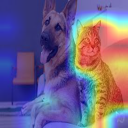

Prompt :  a photo of a dog.


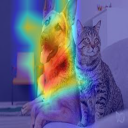

Prompt :  a photo of a dog and a cat.


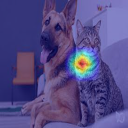

In [32]:
target_layer_gradcam = clip.vision_model.encoder.layers[-2].mlp.fc1
image_resized = image.resize((256, 256))
tensor_resized = transforms.ToTensor()(image_resized)


for i in range(len(prompts)):
    targets_for_gradcam = [ClassifierOutputTarget(i)]
    print("Prompt : ", prompts[i])
    display(Image.fromarray(run_grad_cam_on_image(model=clip,
                          target_layer=target_layer_gradcam,
                          targets_for_gradcam=targets_for_gradcam,
                          input_tensor=tensor_resized,
                          input_image=image_resized,
                          reshape_transform=reshape_transform_vit_huggingface)))

### Observations
- Projection Layer는 cat에 대한 prompt가 주어졌을 때 dog에 집중된 heatmap을, dog에 대한 prompt가 주어졌을 때는 cat에 집중된 heatmap을 보임.
- Fully Connected Layer는 각 Class(dog, cat)에 대해 적절한 heatmap을 보임.
- Fully Connected Layer는 dog와 cat 모두를 찾아야 할 때 각 객체의 매우 일부분에 집중된 heatmap을 보임.

# 실험 2) 서로 다른 깊이의 Transformer Layers에서 실험
- 3번째 Layer
- 5번째 Layer 
- 11번째 Layer

### (1) 3번째 Layer

Prompt :  a photo of a cat.


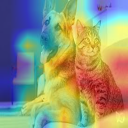

Prompt :  a photo of a dog.


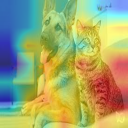

Prompt :  a photo of a dog and a cat.


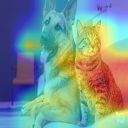

In [49]:
target_layer_gradcam = clip.vision_model.encoder.layers[2].mlp.fc1
image_resized = image.resize((256, 256))
tensor_resized = transforms.ToTensor()(image_resized)


for i in [0,1,2]:
    targets_for_gradcam = [ClassifierOutputTarget(i)]
    print("Prompt : ", prompts[i])
    display(Image.fromarray(run_grad_cam_on_image(model=clip,
                          target_layer=target_layer_gradcam,
                          targets_for_gradcam=targets_for_gradcam,
                          input_tensor=tensor_resized,
                          input_image=image_resized,
                          reshape_transform=reshape_transform_vit_huggingface)))

### (2) 5번째 Layer

Prompt :  a photo of a cat.


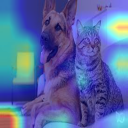

Prompt :  a photo of a dog.


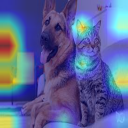

Prompt :  a photo of a dog and a cat.


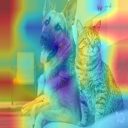

In [27]:
target_layer_gradcam = clip.vision_model.encoder.layers[4].mlp.fc1
image_resized = image.resize((256, 256))
tensor_resized = transforms.ToTensor()(image_resized)


for i in [0,1,2]:
    targets_for_gradcam = [ClassifierOutputTarget(i)]
    print("Prompt : ", prompts[i])
    display(Image.fromarray(run_grad_cam_on_image(model=clip,
                          target_layer=target_layer_gradcam,
                          targets_for_gradcam=targets_for_gradcam,
                          input_tensor=tensor_resized,
                          input_image=image_resized,
                          reshape_transform=reshape_transform_vit_huggingface)))

### (1) 10번째 Layer

Prompt :  a photo of a cat.


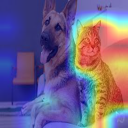

Prompt :  a photo of a dog.


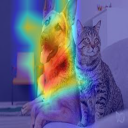

Prompt :  a photo of a dog and a cat.


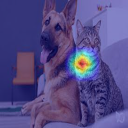

In [28]:
target_layer_gradcam = clip.vision_model.encoder.layers[10].mlp.fc1
image_resized = image.resize((256, 256))
tensor_resized = transforms.ToTensor()(image_resized)


for i in [0,1,2]:
    targets_for_gradcam = [ClassifierOutputTarget(i)]
    print("Prompt : ", prompts[i])
    display(Image.fromarray(run_grad_cam_on_image(model=clip,
                          target_layer=target_layer_gradcam,
                          targets_for_gradcam=targets_for_gradcam,
                          input_tensor=tensor_resized,
                          input_image=image_resized,
                          reshape_transform=reshape_transform_vit_huggingface)))

## Observations
- 더욱 깊은 Layer (출력단과 가까운 Layer)일수록 사람에게 보다 직관적인 heatmap을 보인다.

## 다른 샘플 이미지

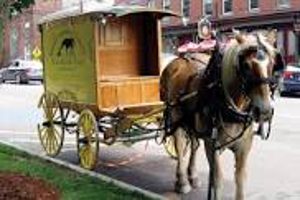

In [29]:
url = "https://public-vcrdata.s3.ap-northeast-2.amazonaws.com/blog/images/Family+and+a+Car.jpg"
url = "https://public-vcrdata.s3.ap-northeast-2.amazonaws.com/blog/images/horse_wagon.jpg"
image = Image.open(requests.get(url, stream=True).raw)
img_tensor = transforms.ToTensor()(image)
image.resize((300,200)).show()

## Example Prompts:
-  "a photo of a horse" 
- "a photo of a wagon"
- "a photo of a horse and a wagon"

In [30]:
prompts = ["a photo of a horse.", "a photo of a wagon.", "a photo of a horse and a wagon."]


In [31]:
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        image = Image.open(requests.get(url, stream=True).raw)
        inputs = processor(
            text=prompts, images=image, return_tensors="pt", padding=True)
        
        output = clip(**inputs)
        return output.logits_per_image

Prompt :  a photo of a horse.


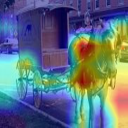

Prompt :  a photo of a wagon.


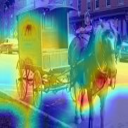

Prompt :  a photo of a horse and a wagon.


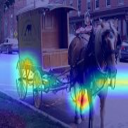

In [32]:
target_layer_gradcam = clip.vision_model.encoder.layers[-2].mlp.fc1
image_resized = image.resize((256, 256))
tensor_resized = transforms.ToTensor()(image_resized)


for i in [0,1,2]:
    targets_for_gradcam = [ClassifierOutputTarget(i)]
    print("Prompt : ", prompts[i])
    display(Image.fromarray(run_grad_cam_on_image(model=clip,
                          target_layer=target_layer_gradcam,
                          targets_for_gradcam=targets_for_gradcam,
                          input_tensor=tensor_resized,
                          input_image=image_resized,
                          reshape_transform=reshape_transform_vit_huggingface)))

# 실험 3) 더 큰 사이즈의 모델에 대한 실험 및 비교

## Model Load

In [33]:
from transformers import CLIPModel, CLIPProcessor, AutoProcessor

clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")

class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        image = Image.open(requests.get(url, stream=True).raw)
        inputs = processor(
            text=prompts, images=image, return_tensors="pt", padding=True)
        
        output = clip(**inputs)
        return output.logits_per_image
    
def reshape_transform_vit_huggingface(x):
    activations = x[:, 1:, :]
    activations = activations.view(activations.shape[0],
                                   16, 16, activations.shape[2])
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations


Prompt :  a photo of a horse.


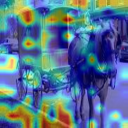

Prompt :  a photo of a wagon.


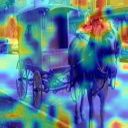

Prompt :  a photo of a horse and a wagon.


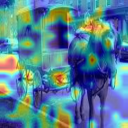

In [34]:
target_layer_gradcam = clip.vision_model.encoder.layers[-2].self_attn.out_proj
image_resized = image.resize((256, 256))
tensor_resized = transforms.ToTensor()(image_resized)


for i in [0,1,2]:
    targets_for_gradcam = [ClassifierOutputTarget(i)]
    print("Prompt : ", prompts[i])
    display(Image.fromarray(run_grad_cam_on_image(model=clip,
                          target_layer=target_layer_gradcam,
                          targets_for_gradcam=targets_for_gradcam,
                          input_tensor=tensor_resized,
                          input_image=image_resized,
                          reshape_transform=reshape_transform_vit_huggingface)))

## Observataions
- Base 모델의 heatmap이 Large 모델의 heatmap보다 사람에게 오히려 더 직관적일 수 있다.

# Results

##### 1. 얕은 layer보다 깊은 layer에서 사람이 식별 가능한 heatmap이 관측된다.
##### 2. Layer에 따라 매우 다른 heatmap이 관측된다.
##### 3. Base Model의 heatmap 결과가 Large Model의 결과보다 사람에게 오히려 더욱 직관적이었다.